In [1]:
# Copyright 2023 DeepMind Technologies Limited
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Imports

In [2]:
# !pip install --upgrade https://github.com/google-deepmind/nuclease-design.git


In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from nuclease_design import utils
from nuclease_design import constants
from nuclease_design import plotting


/var/folders/4g/l2k88w8157j_55v45frbffd0jyc_91/T/ipykernel_46303/4283158963.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
%load_ext autoreload
%autoreload 2

# Constants

In [5]:
sns.set(font_scale=2)
sns.set_style('ticks')

In [6]:
DATA_DIR = constants.DATA_DIR

# Library code

In [7]:
DEFAULT_MAX_INTRA_CLUSTER_HAMMING_DISTANCE = 3

def print_library_sizes(df, hit_calling_kwargs, max_intra_cluster_hamming_distance=DEFAULT_MAX_INTRA_CLUSTER_HAMMING_DISTANCE):
  print('Input library')
  print('size:')
  print(df['sublibrary_name'].value_counts())
  print('num clusters:')
  print(df.groupby('sublibrary_name')['sequence'].apply(utils.num_sequence_clusters, max_intra_cluster_hamming_distance))

  print('Hits')
  hit_df = df.groupby('sublibrary_name').apply(utils.select_hit_rows, **hit_calling_kwargs).reset_index(drop=True)
  print('size:')
  print(hit_df['sublibrary_name'].value_counts())
  print('num clusters:')
  print(hit_df.groupby('sublibrary_name')['sequence'].apply(utils.num_sequence_clusters, max_intra_cluster_hamming_distance))


# Load data

In [8]:
all_data_df = utils.load_all_data(data_dir=DATA_DIR)
df = utils.expand_sublibraries(all_data_df)
df['campaign'] = df['sublibrary_name'].apply(lambda s: 'HR' if s.endswith('recombination') else 'ML')

with utils.open_file(constants.NUM_CLUSTERS_G4_PATH, 'r', DATA_DIR) as f:
  num_clusters_g4_df = pd.read_csv(f)

with utils.open_file(constants.NUM_CLUSTERS_ZERO_SHOT_PATH, 'r', DATA_DIR) as f:
  num_clusters_zero_shot_df = pd.read_csv(f)

In [9]:
# The use of 'campaign' in the num_clusters files is misleading
# because the clusters are not for all of ML4, but instead the mbo-dnn
# sublibrary.
campaign_rename_dict = dict(HR='HR4', ML='ML4-MBO-DNN')
df['library'] = df['campaign'].apply(campaign_rename_dict.get)
num_clusters_g4_df['library'] = num_clusters_g4_df['campaign'].apply(campaign_rename_dict.get)

# G4 MBO_DNN vs. Baseline

In [10]:
g4_comparison_df = df[df['sublibrary_name'].isin(['g4_mbo_dnn', 'g4_hit_recombination'])]

In [11]:
hit_calling_kwargs = dict(
    reference_name='wt', expected_false_discovery_rate=utils.EXPECTED_FDR
)
print_library_sizes(g4_comparison_df, hit_calling_kwargs)

Input library
size:
sublibrary_name
g4_hit_recombination    1540
g4_mbo_dnn              1356
Name: count, dtype: int64
num clusters:
sublibrary_name
g4_hit_recombination    501
g4_mbo_dnn              858
Name: sequence, dtype: int32
Hits
size:
sublibrary_name
g4_mbo_dnn              1146
g4_hit_recombination     890
Name: count, dtype: int64
num clusters:


/var/folders/4g/l2k88w8157j_55v45frbffd0jyc_91/T/ipykernel_46303/3328977102.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hit_df = df.groupby('sublibrary_name').apply(utils.select_hit_rows, **hit_calling_kwargs).reset_index(drop=True)


sublibrary_name
g4_hit_recombination    297
g4_mbo_dnn              733
Name: sequence, dtype: int32


In [12]:
hit_calling_kwargs = dict(
    reference_name='a73r', expected_false_discovery_rate=utils.EXPECTED_FDR
)
print_library_sizes(g4_comparison_df, hit_calling_kwargs)

Input library
size:
sublibrary_name
g4_hit_recombination    1540
g4_mbo_dnn              1356
Name: count, dtype: int64
num clusters:
sublibrary_name
g4_hit_recombination    501
g4_mbo_dnn              858
Name: sequence, dtype: int32
Hits
size:
sublibrary_name
g4_mbo_dnn              52
g4_hit_recombination     8
Name: count, dtype: int64
num clusters:
sublibrary_name
g4_hit_recombination     5
g4_mbo_dnn              42
Name: sequence, dtype: int32


/var/folders/4g/l2k88w8157j_55v45frbffd0jyc_91/T/ipykernel_46303/3328977102.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hit_df = df.groupby('sublibrary_name').apply(utils.select_hit_rows, **hit_calling_kwargs).reset_index(drop=True)


In [13]:
# add pre-sort label
num_clusters_g4_df['activity_label'] = num_clusters_g4_df['activity_label'].apply(lambda x: 'pre-sort' if x == 'all' else x)
num_clusters_g4_df.head()

,campaign,level_1,num_clusters,activity_label,max_intra_cluster_hamming_distance,population,library
0,HR,0,979,pre-sort,0,pre-sort,HR4
1,HR,1,958,pre-sort,0,pre-sort,HR4
2,HR,2,972,pre-sort,0,pre-sort,HR4
3,HR,3,980,pre-sort,0,pre-sort,HR4
4,HR,4,952,pre-sort,0,pre-sort,HR4


In [14]:
# rename
num_clusters_g4_df['population'] = num_clusters_g4_df['activity_label'].astype(str)
num_clusters_g4_df['population'] = num_clusters_g4_df['population'].str.replace('a73r', 'A73R')

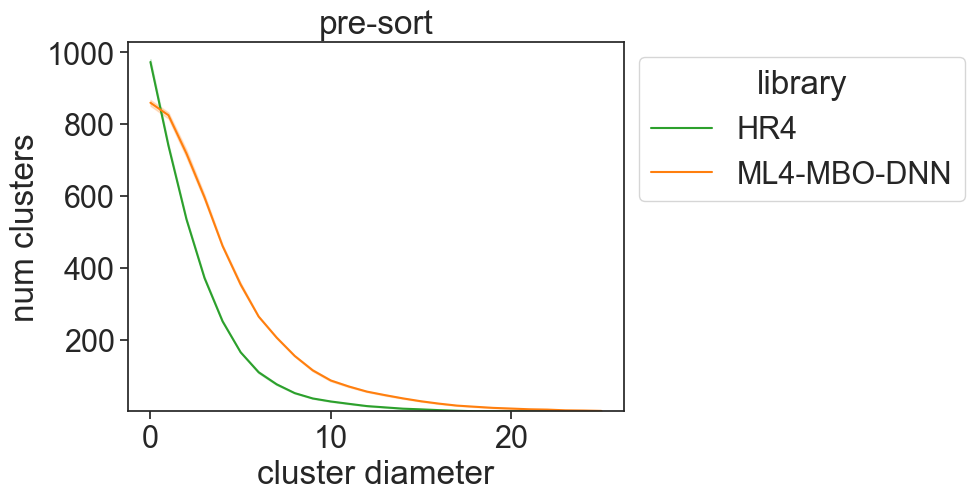

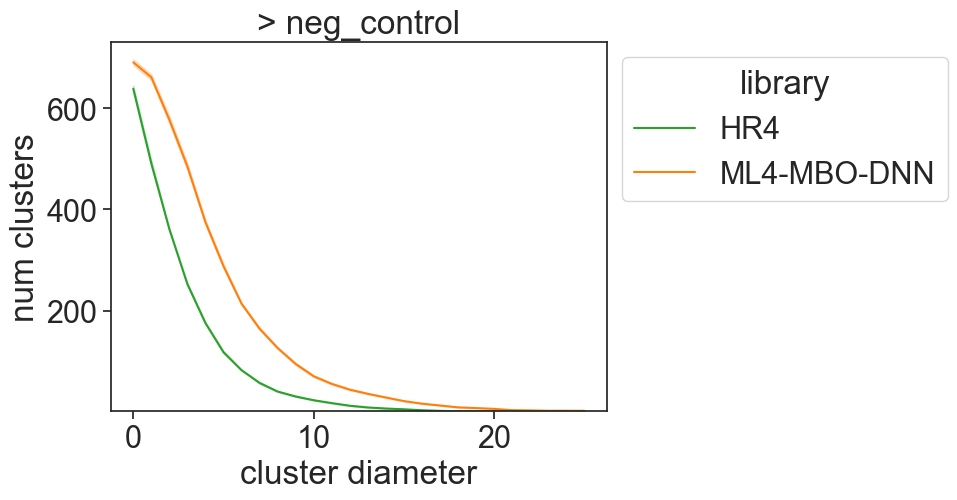

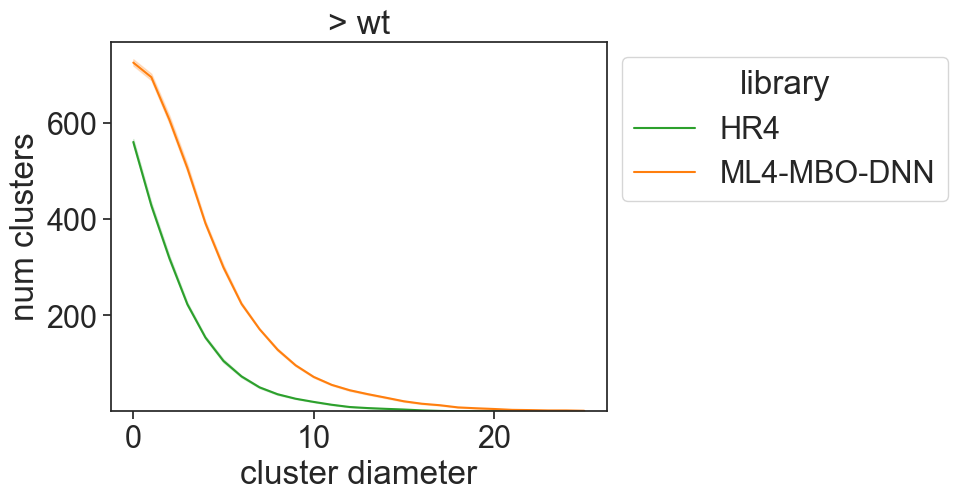

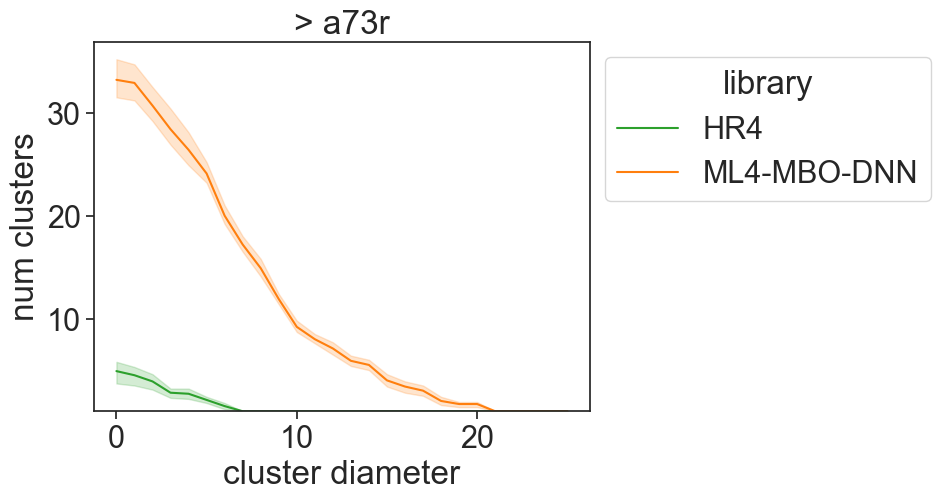

In [15]:
for activity_label in num_clusters_g4_df['activity_label'].unique():
  plotdf = num_clusters_g4_df[
      num_clusters_g4_df['activity_label'] == activity_label
  ]
  ax = sns.lineplot(
      data=plotdf,
      x='max_intra_cluster_hamming_distance',
      y='num_clusters',
      hue='library',
      hue_order=['HR4', 'ML4-MBO-DNN'],
      palette=[plotting.HR_COLOR, plotting.ML_COLOR],
  )
  sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
  plt.title(activity_label)
  plt.ylabel('Number of clusters')
  plt.xlabel('Cluster diameter')
  plotting.remove_underscores_from_axis_labels(ax)
  plt.ylim(bottom=1.0)
  plt.show()

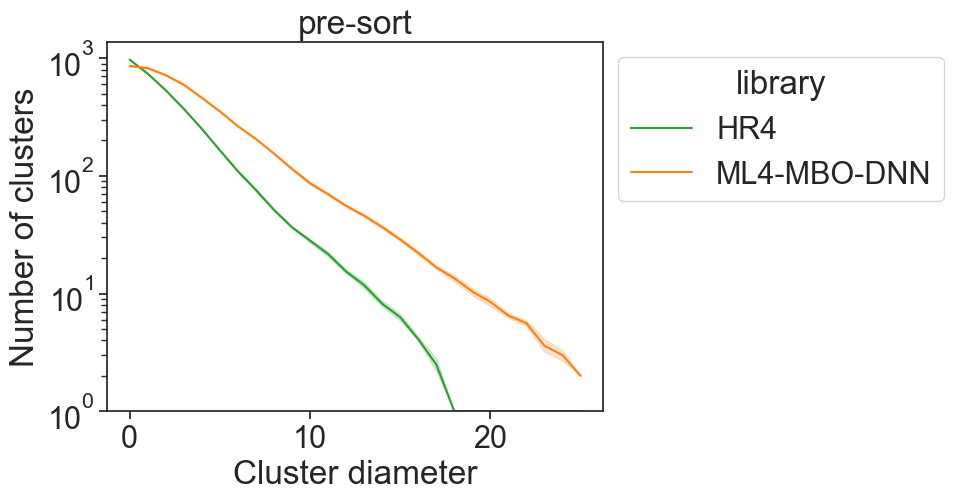

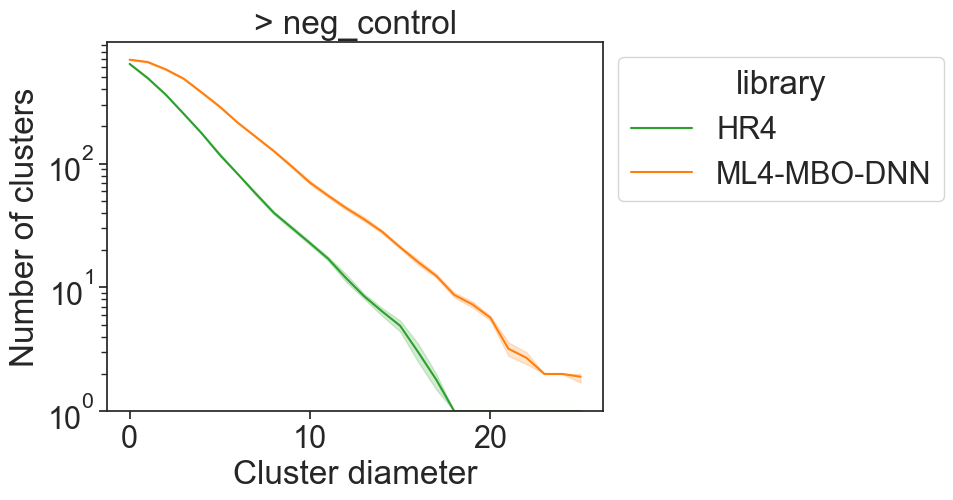

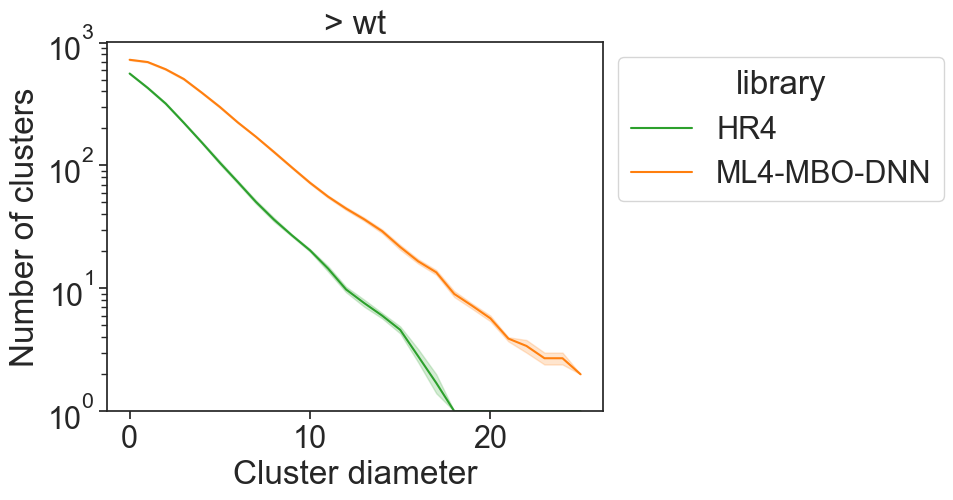

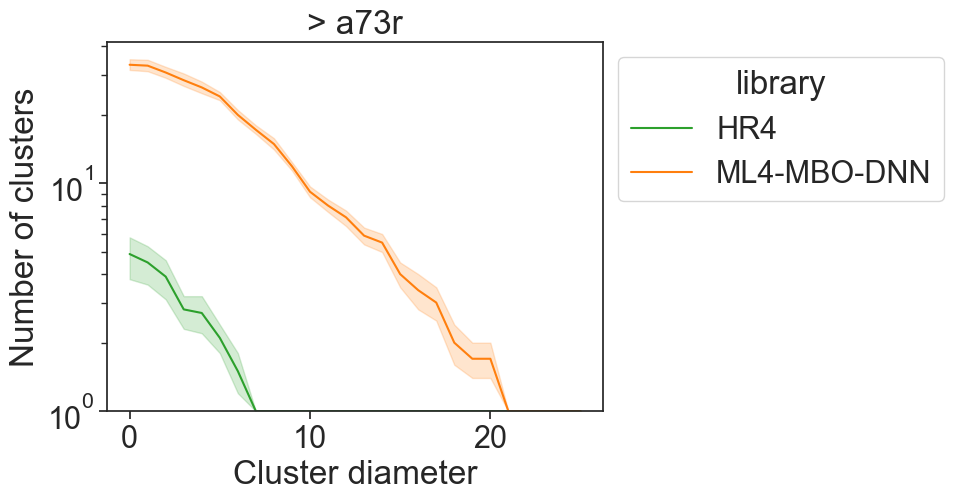

In [16]:
for activity_label in num_clusters_g4_df['activity_label'].unique():
  plotdf = num_clusters_g4_df[
      num_clusters_g4_df['activity_label'] == activity_label
  ]
  ax = sns.lineplot(
      data=plotdf,
      x='max_intra_cluster_hamming_distance',
      y='num_clusters',
      hue='library',
      hue_order=['HR4', 'ML4-MBO-DNN'],
      palette=[plotting.HR_COLOR, plotting.ML_COLOR],
  )
  ax.set(yscale='log')
  plotting.remove_underscores_from_axis_labels(ax)
  plt.ylabel('Number of clusters')
  plt.xlabel('Cluster diameter')
  sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
  plt.title(activity_label)
  plt.ylim(bottom=1.0)
  plt.show()

### overlaid with full library clustering

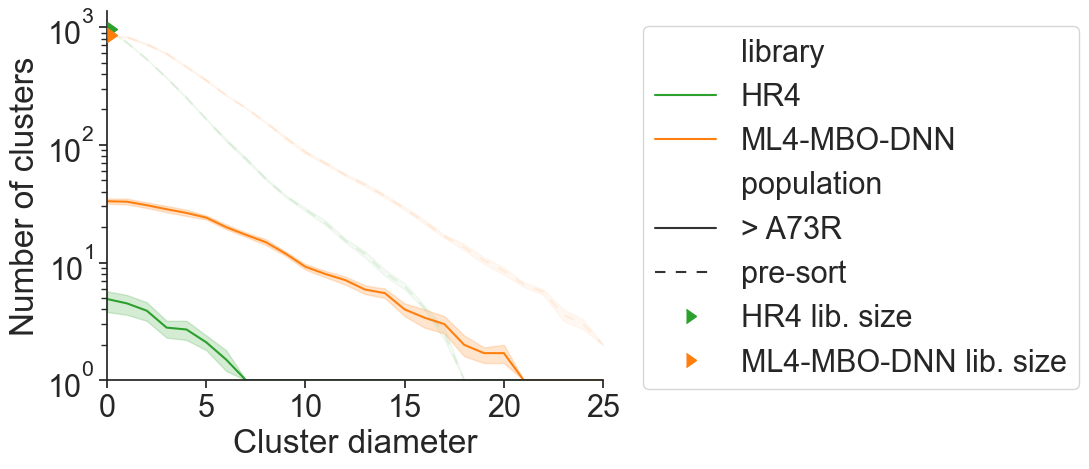

In [17]:
ax = plotting.plot_diversity_overlay(
    num_clusters_g4_df, '> A73R', 'library',
    hue_order=['HR4', 'ML4-MBO-DNN'],
    palette=[plotting.HR_COLOR, plotting.ML_COLOR],
)

<Axes: xlabel='Cluster diameter', ylabel='Number of clusters'>

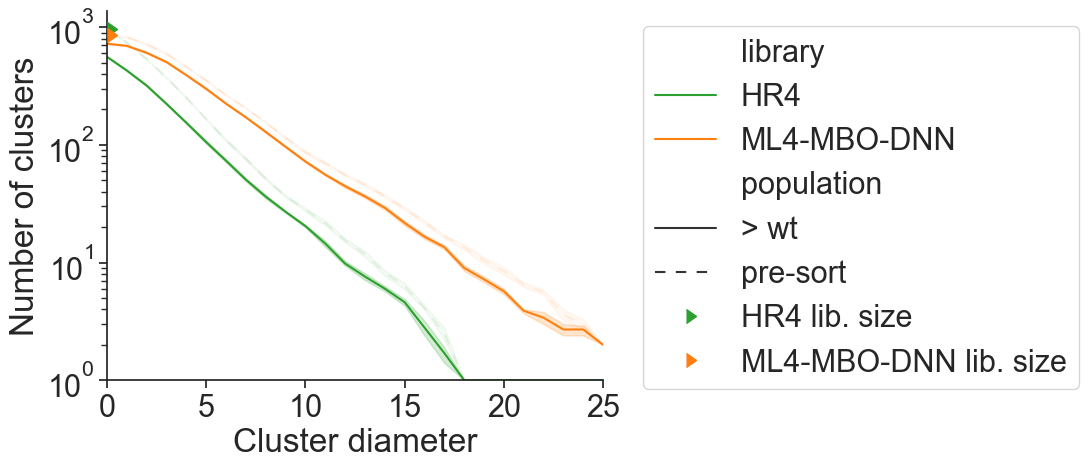

In [18]:
plotting.plot_diversity_overlay(
    num_clusters_g4_df, '> wt', 'library',
    hue_order=['HR4', 'ML4-MBO-DNN'],
    palette=[plotting.HR_COLOR, plotting.ML_COLOR],
)

# Zero-shot

In [19]:
g1_df = df[df.generation == 'g1'].reset_index(drop=True)

In [20]:
zero_shot_and_g1_df = pd.concat([df[df['sublibrary_name'] == 'zero_shot'], g1_df])

In [21]:
hit_calling_kwargs = dict(
    reference_name='wt', expected_false_discovery_rate=utils.EXPECTED_FDR
)
print_library_sizes(zero_shot_and_g1_df, hit_calling_kwargs)

Input library
size:
sublibrary_name
g1_eppcr     9441
zero_shot    1235
Name: count, dtype: int64
num clusters:
sublibrary_name
g1_eppcr     3167
zero_shot     448
Name: sequence, dtype: int32
Hits
size:
sublibrary_name
g1_eppcr     155
zero_shot    134
Name: count, dtype: int64
num clusters:
sublibrary_name
g1_eppcr     33
zero_shot    74
Name: sequence, dtype: int32


/var/folders/4g/l2k88w8157j_55v45frbffd0jyc_91/T/ipykernel_46303/3328977102.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hit_df = df.groupby('sublibrary_name').apply(utils.select_hit_rows, **hit_calling_kwargs).reset_index(drop=True)


In [22]:
# add pre-sort label
num_clusters_zero_shot_df['activity_label'] = num_clusters_zero_shot_df['activity_label'].apply(lambda x: 'pre-sort' if x == 'all' else x)

In [23]:
# rename activity_label to population
num_clusters_zero_shot_df['population'] = num_clusters_zero_shot_df[
    'activity_label'
].astype(str)
num_clusters_zero_shot_df['population'] = num_clusters_zero_shot_df[
    'population'
].str.replace('a73r', 'A73R')
num_clusters_zero_shot_df['population'] = num_clusters_zero_shot_df[
    'population'
].str.replace('neg_control', 'negative control')
num_clusters_zero_shot_df['population'] = num_clusters_zero_shot_df[
    'population'
].str.replace('wt', 'parent')
num_clusters_zero_shot_df['sublibrary name'] = (
    num_clusters_zero_shot_df['sublibrary_name']
    .str.replace('zero_shot', 'zero-shot sampling')
    .str.replace('g1_eppcr', 'epPCR')
)

In [24]:
num_clusters_zero_shot_df.head()

,sublibrary_name,level_1,num_clusters,activity_label,max_intra_cluster_hamming_distance,population,sublibrary name
0,g1_eppcr,0,5990,pre-sort,0,pre-sort,epPCR
1,g1_eppcr,1,5981,pre-sort,0,pre-sort,epPCR
2,g1_eppcr,2,5889,pre-sort,0,pre-sort,epPCR
3,g1_eppcr,3,5961,pre-sort,0,pre-sort,epPCR
4,g1_eppcr,4,5977,pre-sort,0,pre-sort,epPCR


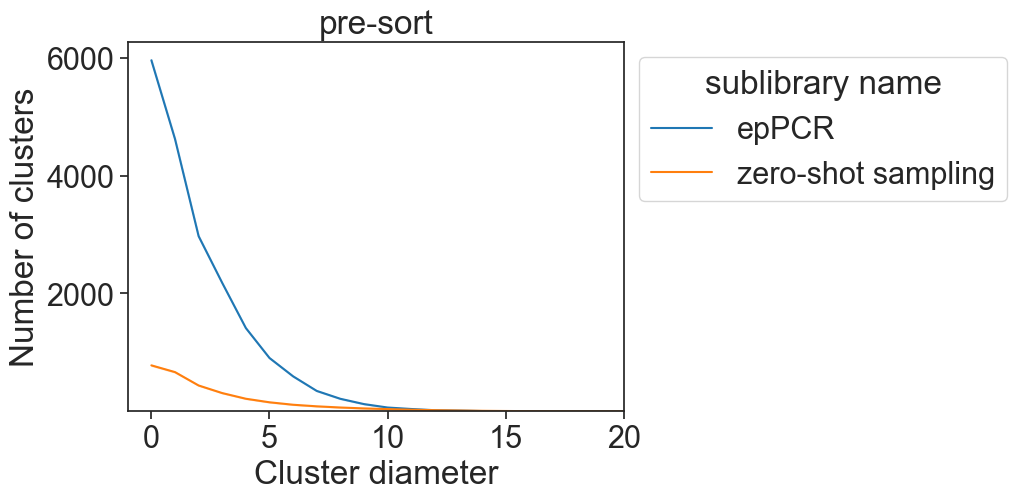

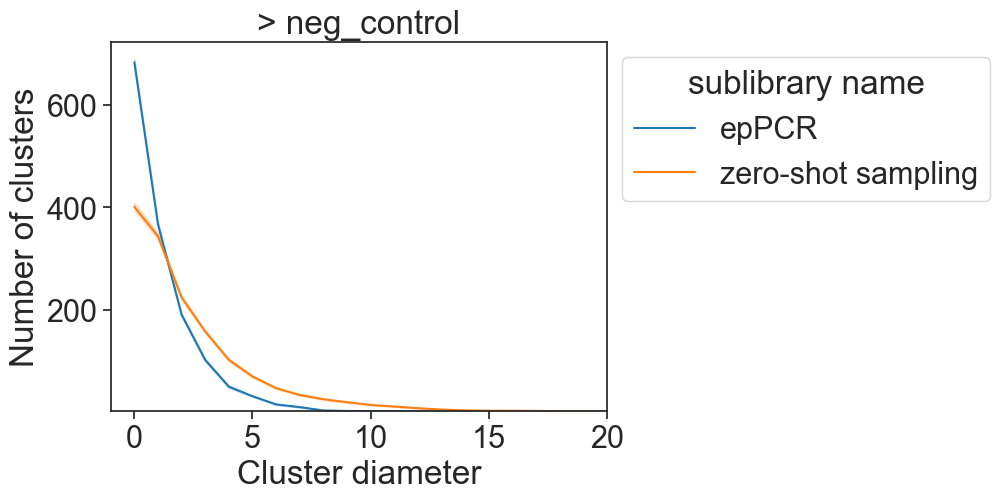

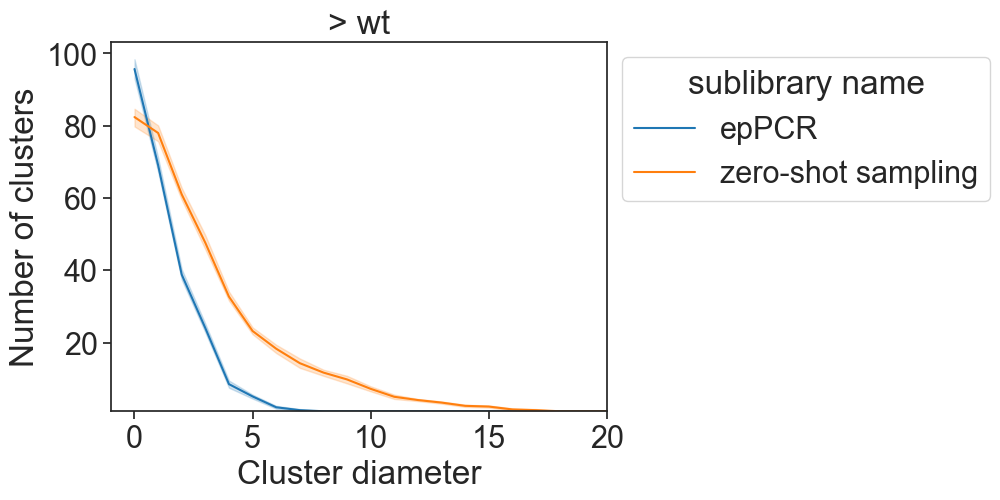

In [25]:
for activity_label in num_clusters_zero_shot_df['activity_label'].unique():
  plotdf = num_clusters_zero_shot_df[
      num_clusters_zero_shot_df['activity_label'] == activity_label
  ].copy()
  ax = sns.lineplot(
      data=plotdf,
      x='max_intra_cluster_hamming_distance',
      y='num_clusters',
      hue='sublibrary name',
      palette=[plotting.EPPCR_COLOR, plotting.ML_COLOR],
  )
  plotting.remove_underscores_from_axis_labels(ax)
  sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
  plt.title(activity_label)
  plt.ylabel('Number of clusters')
  plt.xlabel('Cluster diameter')
  plt.ylim(bottom=1.0)
  plt.xlim(right=20)
  plt.show()

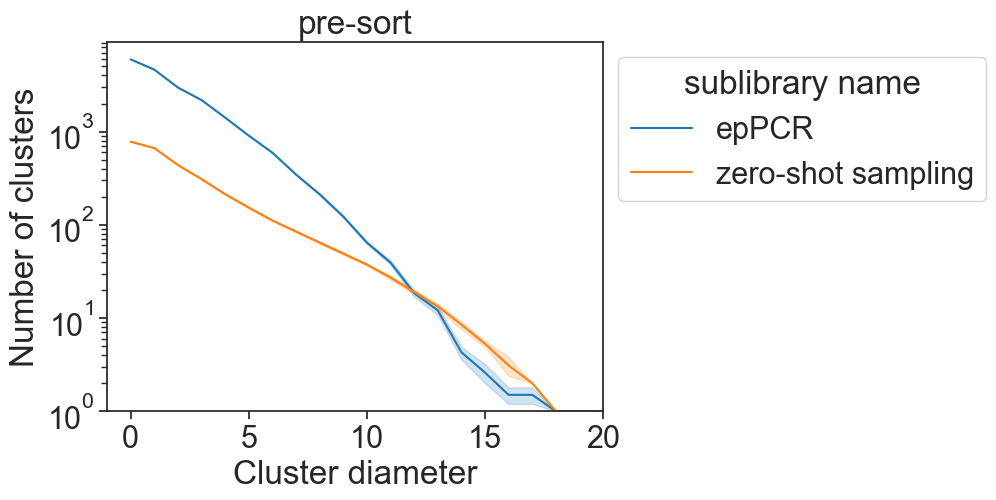

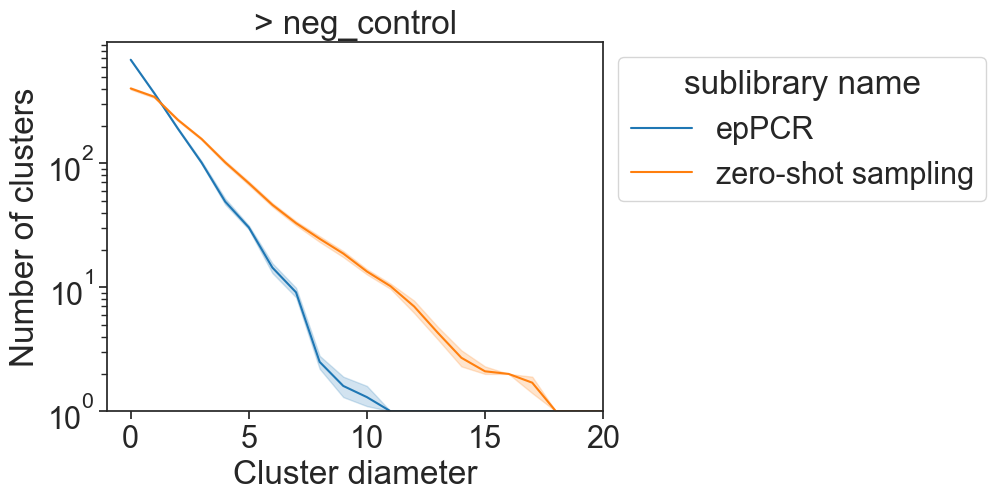

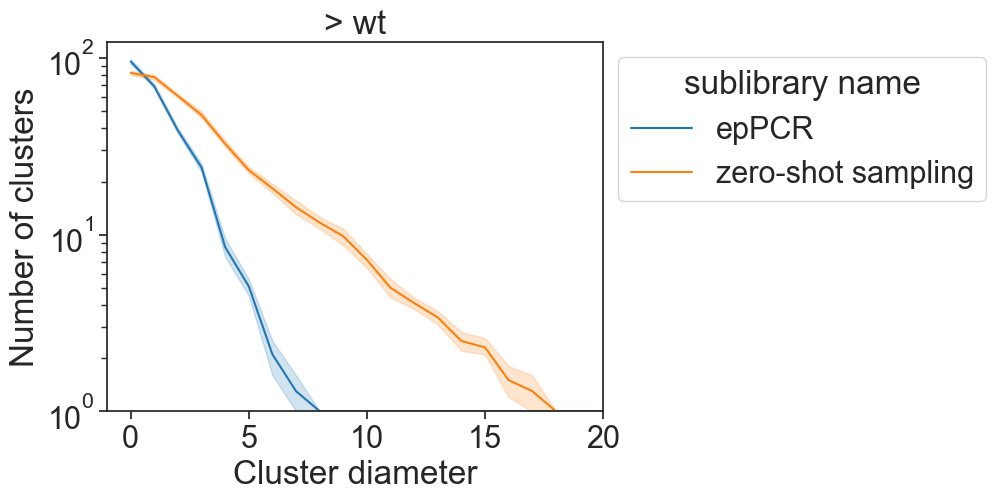

In [26]:
for activity_label in num_clusters_zero_shot_df['activity_label'].unique():
  plotdf = num_clusters_zero_shot_df[
      num_clusters_zero_shot_df['activity_label'] == activity_label
  ].copy()
  ax = sns.lineplot(
      data=plotdf,
      x='max_intra_cluster_hamming_distance',
      y='num_clusters',
      hue='sublibrary name',
      palette=[plotting.EPPCR_COLOR, plotting.ML_COLOR],
  )
  ax.set(yscale='log')
  plotting.remove_underscores_from_axis_labels(ax)
  plt.ylabel('Number of clusters')
  plt.xlabel('Cluster diameter')
  sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
  plt.title(activity_label)
  plt.ylim(bottom=1.0)
  plt.xlim(right=20)
  plt.show()

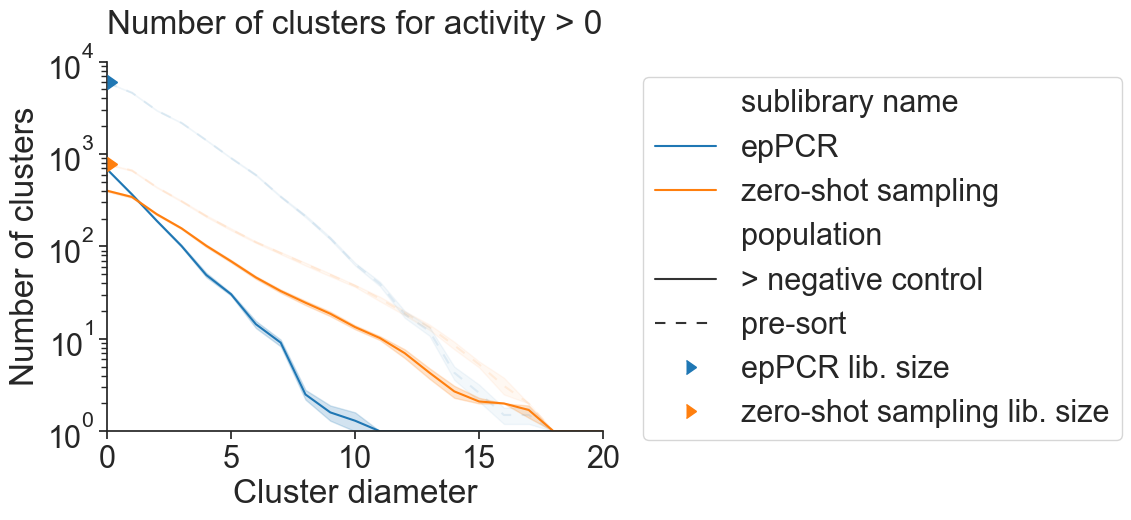

In [27]:
plotting.plot_diversity_overlay(
    num_clusters_zero_shot_df,
    '> negative control',
    'sublibrary name',
    ['epPCR', 'zero-shot sampling'],
    palette=[plotting.EPPCR_COLOR, plotting.ML_COLOR],
    xticks_max=21,
)
plt.title('Number of clusters for activity > 0', pad=20)
_ = plt.ylim(top=1e4)
#plt.gca().get_legend().get_title().set_text('sampling method')

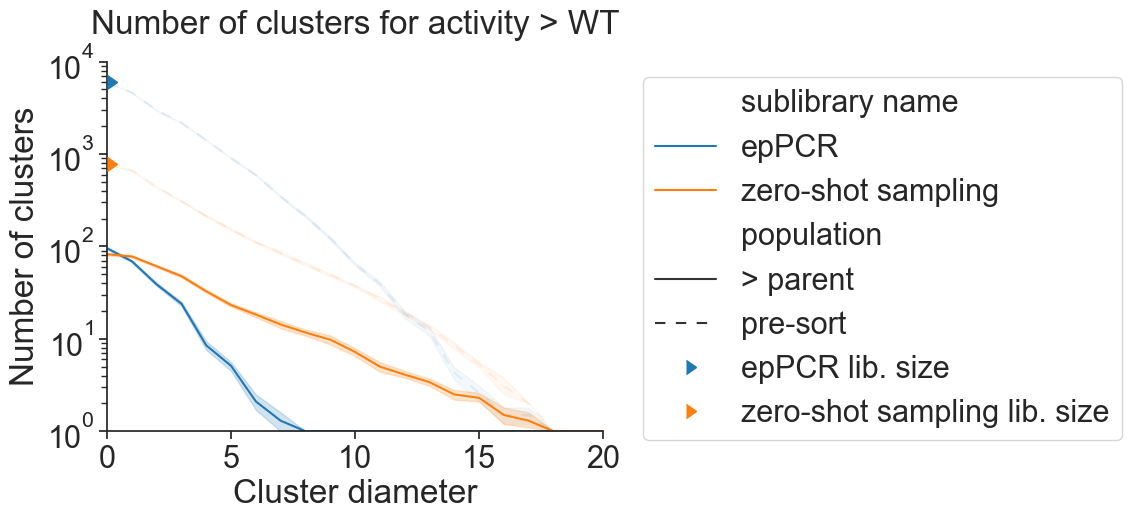

In [28]:
plotting.plot_diversity_overlay(
    num_clusters_zero_shot_df,
    '> parent',
    'sublibrary name',
    ['epPCR', 'zero-shot sampling'],
    palette=[plotting.EPPCR_COLOR, plotting.ML_COLOR],
    xticks_max=21,
)
plt.title('Number of clusters for activity > WT', pad=20)
_ = plt.ylim(top=1e4)
#plt.gca().get_legend().remove()